In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
import pandas as pd
import pickle
from helper import *


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
K.set_floatx("float32")

In [3]:
k = 8
J = 32
save_time_step = 0.005
h=1 
F=20
c=10
b=10

# Prepare data #

In [4]:
history_length = 100
test_seq_length = 1000

In [5]:
#load train, validation and test datasets 
train_dataset = np.load("../../data/truth_run/training_dataset.npy")
valid_dataset = np.load("../../data/truth_run/val_dataset.npy")

In [6]:
x_train = train_dataset[:,:,0]
x_valid = valid_dataset[:,:,0]

In [7]:
##### Functions to work out the exact U for each x #########

def _rhs_X_dt(X, U,dt=0.005):
    """Compute the right hand side of the X-ODE."""

    dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                X + F - U)

    return dt * dXdt 


def U(Xt,Xt_1,dt=0.005):
    k1_X = _rhs_X_dt(Xt, U=0)
    k2_X = _rhs_X_dt(Xt + k1_X / 2, U=0)
    Xt_1_pred = k2_X + Xt 
    #print(Xt_1_pred)
    Ut = (Xt_1_pred - Xt_1 )/dt

    return Ut

In [8]:
u_t = U(x_train[:-1,:],x_train[1:,:])    
u_t_valid = U(x_valid[:-1,:],x_valid[1:,:])  

In [9]:
training_dataset = np.stack([x_train[:-1],u_t],axis=2)
valid_dataset = np.stack([x_valid[:-1],u_t_valid],axis=2)


In [10]:
def prepare_datasets_for_RNN(dataset,history_length):
    max_index = (dataset.shape[0]-1)//history_length
    dataset = dataset[:(max_index*history_length +1),:,:] 
    dataset_shape = dataset.shape[0]
    last_elements = dataset[-1,:,:]
    remaining_dataset = dataset[:-1,:,:]
    reshaped = remaining_dataset.reshape(-1,history_length,k,2)
    add_on = reshaped[1:,:1,:,:]
    last_elements = last_elements.reshape(1,1,k,2)
    add_on_combined = np.concatenate((add_on,last_elements),axis=0)
    concat = np.concatenate((reshaped,add_on_combined),axis=1)
    concat = concat.transpose((2,0,1,3)).reshape((-1,history_length+1,2),order="F")
    return concat.astype("float32")

In [11]:
train_nn_features = prepare_datasets_for_RNN(training_dataset,history_length)
valid_nn_features = prepare_datasets_for_RNN(valid_dataset,test_seq_length)

In [12]:
x_mean = np.mean(train_nn_features[:,:,0])
x_std = np.std(train_nn_features[:,:,0])
u_mean = np.mean(train_nn_features[:,:,1])
u_std = np.std(train_nn_features[:,:,1])

In [13]:
#scaling
train_nn_features[:,:,0] = (train_nn_features[:,:,0] - x_mean)/x_std
train_nn_features[:,:,1] = (train_nn_features[:,:,1] - u_mean)/u_std

In [14]:
#scaling
valid_nn_features[:,:,0] = (valid_nn_features[:,:,0] - x_mean)/x_std
valid_nn_features[:,:,1] = (valid_nn_features[:,:,1] - u_mean)/u_std

In [15]:
#train_nn_features_tf = tf.convert_to_tensor(train_nn_features)
valid_nn_features_tf = tf.convert_to_tensor(valid_nn_features)

In [21]:
@tf.function
def sample_from_encoder(xu_seq,encoder,first_encoder,encoder_hidden_state_size,bi_rnn):
    
    length = xu_seq.shape[1]
    batch_shape = xu_seq.shape[0]
    
    h_sequence = tf.TensorArray(dtype=tf.float32,size=0,dynamic_size=True)
    h_mean_out = tf.TensorArray(dtype=tf.float32,size=0,dynamic_size=True)
    h_log_var_out = tf.TensorArray(dtype=tf.float32,size=0,dynamic_size=True)
    
    u_summary = bi_rnn(xu_seq[:,:-1,:])

    h_mean1,h_log_var1,h_prev = first_encoder([xu_seq[:,0,0],u_summary[:,0,0]])
    h_sequence = h_sequence.write(0,h_prev)
    h_mean_out = h_mean_out.write(0,h_mean1)
    h_log_var_out = h_log_var_out.write(0,h_log_var1)

    
    hidden_state_1 = tf.zeros(shape=(batch_shape,encoder_hidden_state_size))
    hidden_state_2 = tf.zeros(shape=(batch_shape,encoder_hidden_state_size))    
    
    for n in tf.range(0,length-2):
        h_mean,h_log_var,h_sample,state,state2 = encoder([h_prev,u_summary[:,n+1:n+2,:],xu_seq[:,n+1:n+2,:1],
                                                    hidden_state_1,hidden_state_2])
        
        h_sequence = h_sequence.write(n+1,h_sample)
        h_prev = h_sample
        h_mean_out = h_mean_out.write(n+1,h_mean)
        h_log_var_out = h_log_var_out.write(n+1,h_log_var) 
        hidden_state_1 = state  
        hidden_state_2 = state2     
        
    h_sequence = h_sequence.stack()        
    h_mean_out_enc = h_mean_out.stack()
    h_log_var_out = h_log_var_out.stack()
    h_sequence = tf.transpose(h_sequence[:,:,0,:],[1,0,2])            
    h_mean_out_enc = tf.transpose(h_mean_out_enc[:,:,0,:],[1,0,2])
    h_log_var_out = tf.transpose(h_log_var_out[:,:,0,:],[1,0,2])

    return h_sequence,h_mean_out_enc,h_log_var_out
        

In [29]:
sigma_gan = 0.001

# Check on importance sampler # 

This shows what the importance sampler does (encodes x,u to h such that the generator will decode x,h back to u).

In [ ]:
generator = keras.models.load_model("gan_generator_final.h5")

codings_size = 1 + 1 + 2*16

In [33]:
h_encoder = keras.models.load_model("h_encoder_final.h5",custom_objects={
           "Sampling":Sampling})
bi_rnn = keras.models.load_model("bi_rnn_final.h5")
h_encoder_first = keras.models.load_model("h_encoder_first_final.h5",custom_objects={
           "Sampling":Sampling})


In [34]:
#encode seq

seq_to_test = train_nn_features[11:12,:,:]

h_sequence,h_mean_out_enc,h_log_var_out = sample_from_encoder(seq_to_test,h_encoder,h_encoder_first,
                                                    encoder_hidden_state_size,bi_rnn)


In [35]:
x_array =  seq_to_test[:,:-1,:1]
x_array_reshape = tf.reshape(x_array,(-1,1))
h_encoding_reshape = tf.reshape(h_mean_out_enc,(-1,h_shape))

In [36]:
#decode the mean
decoded_mean_u = generator([x_array_reshape,h_encoding_reshape])



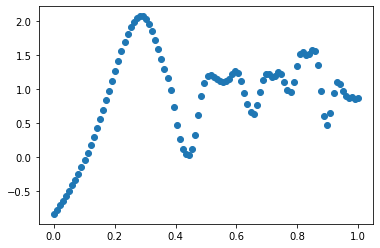

In [37]:
#plot of u_true against time 
plt.scatter(y=np.ravel(seq_to_test[:,:-1,1:]),x=np.linspace(0,1,100))

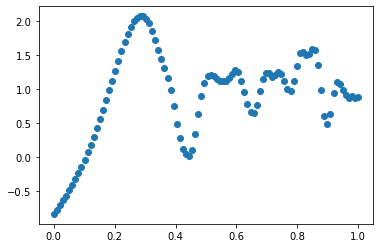

In [38]:
#plot of u against time after x and u summary have been encoded and then decoded using the gan. Good match to above. 
#The encoding models have carried out learning.
plt.scatter(y=np.ravel(decoded_mean_u),x=np.linspace(0,1,100))